In [1]:
pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
import torch
import torch.nn as nn
from torchvision import models
import random
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import os
import underthesea
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.nn.utils.rnn import pad_sequence
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Download NLTK tokenizer data
nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
path_caption ='/kaggle/input/data-caption-to-vietnamese/data.csv'
path_img = '/kaggle/input/automatic-image-captioning-for-visually-impaired/visuallyimpair/visual_dataset'

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)
    
    def tokenizer_eng(self, text):
        # Use underthesea for Vietnamese tokenization
        return underthesea.word_tokenize(text, format="text").split()
    
    def build_vocabulary(self, sentence_list):
        frequency = {}
        idx = 4  # Start indexing from 4 because 0-3 are reserved for special tokens

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1

                if frequency[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi.get(word, self.stoi["<UNK>"]) for word in tokenized_text]


In [5]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_path, freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pd.read_csv(caption_path).drop('Unnamed: 0', axis=1)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [6]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self, batch):
        imgs = [item[0] for item in batch]  # Assuming each item in the batch is (image, caption)
        captions = [item[1] for item in batch]
        
        # Convert list of images into a batched tensor
        imgs = torch.stack(imgs, dim=0)
        
        # Pad the captions using the pad_value
        captions = pad_sequence(captions, batch_first=True, padding_value=self.pad_value)
        
        return imgs, captions


In [7]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to the correct dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB images
])

In [8]:
def get_loader(root_dir, caption_path, transform=transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=8, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value=dataset.vocab.stoi["<PAD>"]), drop_last=True)
    return loader, dataset

In [9]:
loader, dataset = get_loader(path_img,path_caption,transform)

8000


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [11]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

In [12]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)


            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [13]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [14]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [15]:
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [16]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

In [17]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [18]:
num_epochs = 100
print_every = 100
loss_values = []
for epoch in range(1, num_epochs + 1):   
    for idx, (image, captions) in enumerate(tqdm(loader, desc=f"Epoch {epoch}")):
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx + 1) % print_every == 0:
            tqdm.write("Epoch: {} Iteration: {} Loss: {:.5f}".format(epoch, idx + 1, loss.item()))

            # Append the loss value to the list
            loss_values.append(loss.item())

            # If you want to generate captions and display images, you can uncomment the following lines
            # model.eval()
            # with torch.no_grad():
            #     dataiter = iter(loader)
            #     img, _ = next(dataiter)
            #     features = model.encoder(img[0:1].to(device))
            #     caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
            #     caption = ' '.join(caps)
            #     show_image(img[0], title=caption)
            # model.train()

    # Save the model after each epoch
    save_model(model, epoch)


Epoch 1:  40%|████      | 100/250 [00:31<00:39,  3.79it/s]

Epoch: 1 Iteration: 100 Loss: 1.61897


Epoch 1:  80%|████████  | 200/250 [00:59<00:13,  3.72it/s]

Epoch: 1 Iteration: 200 Loss: 0.97479


Epoch 2:  40%|████      | 100/250 [00:31<00:38,  3.88it/s]

Epoch: 2 Iteration: 100 Loss: 0.40605


Epoch 2:  80%|████████  | 200/250 [00:58<00:13,  3.61it/s]

Epoch: 2 Iteration: 200 Loss: 0.27716


Epoch 3:  40%|████      | 100/250 [00:31<00:38,  3.94it/s]

Epoch: 3 Iteration: 100 Loss: 0.19841


Epoch 3:  80%|████████  | 200/250 [00:57<00:15,  3.22it/s]

Epoch: 3 Iteration: 200 Loss: 0.23109


Epoch 4:  40%|████      | 100/250 [00:29<00:44,  3.36it/s]

Epoch: 4 Iteration: 100 Loss: 0.18559


Epoch 4:  80%|████████  | 200/250 [00:56<00:15,  3.27it/s]

Epoch: 4 Iteration: 200 Loss: 0.21867


Epoch 5:  40%|████      | 100/250 [00:30<00:41,  3.65it/s]

Epoch: 5 Iteration: 100 Loss: 0.19413


Epoch 5:  80%|████████  | 200/250 [00:56<00:11,  4.26it/s]

Epoch: 5 Iteration: 200 Loss: 0.19710


Epoch 6:  40%|████      | 100/250 [00:30<00:42,  3.57it/s]

Epoch: 6 Iteration: 100 Loss: 0.19916


Epoch 6:  80%|████████  | 200/250 [00:56<00:14,  3.50it/s]

Epoch: 6 Iteration: 200 Loss: 0.15295


Epoch 7:  40%|████      | 100/250 [00:29<00:35,  4.24it/s]

Epoch: 7 Iteration: 100 Loss: 0.18178


Epoch 7:  80%|████████  | 200/250 [00:56<00:12,  3.87it/s]

Epoch: 7 Iteration: 200 Loss: 0.17804


Epoch 8:  40%|████      | 100/250 [00:30<00:38,  3.89it/s]

Epoch: 8 Iteration: 100 Loss: 0.18943


Epoch 8:  80%|████████  | 200/250 [00:57<00:12,  4.01it/s]

Epoch: 8 Iteration: 200 Loss: 0.15680


Epoch 9:  40%|████      | 100/250 [00:29<00:41,  3.63it/s]

Epoch: 9 Iteration: 100 Loss: 0.15562


Epoch 9:  80%|████████  | 200/250 [00:56<00:13,  3.66it/s]

Epoch: 9 Iteration: 200 Loss: 0.12926


Epoch 10:  40%|████      | 100/250 [00:30<00:38,  3.94it/s]

Epoch: 10 Iteration: 100 Loss: 0.13218


Epoch 10:  80%|████████  | 200/250 [00:56<00:11,  4.34it/s]

Epoch: 10 Iteration: 200 Loss: 0.13342


Epoch 11:  40%|████      | 100/250 [00:30<00:38,  3.88it/s]

Epoch: 11 Iteration: 100 Loss: 0.14242


Epoch 11:  80%|████████  | 200/250 [00:56<00:13,  3.76it/s]

Epoch: 11 Iteration: 200 Loss: 0.14712


Epoch 12:  40%|████      | 100/250 [00:30<00:37,  4.03it/s]

Epoch: 12 Iteration: 100 Loss: 0.12586


Epoch 12:  80%|████████  | 200/250 [00:56<00:14,  3.45it/s]

Epoch: 12 Iteration: 200 Loss: 0.15248


Epoch 13:  40%|████      | 100/250 [00:30<00:40,  3.66it/s]

Epoch: 13 Iteration: 100 Loss: 0.13477


Epoch 13:  80%|████████  | 200/250 [00:56<00:11,  4.21it/s]

Epoch: 13 Iteration: 200 Loss: 0.13364


Epoch 14:  40%|████      | 100/250 [00:30<00:37,  3.99it/s]

Epoch: 14 Iteration: 100 Loss: 0.17897


Epoch 14:  80%|████████  | 200/250 [00:56<00:12,  3.90it/s]

Epoch: 14 Iteration: 200 Loss: 0.14375


Epoch 15:  40%|████      | 100/250 [00:30<00:41,  3.59it/s]

Epoch: 15 Iteration: 100 Loss: 0.12843


Epoch 15:  80%|████████  | 200/250 [00:55<00:12,  4.03it/s]

Epoch: 15 Iteration: 200 Loss: 0.09127


Epoch 16:  40%|████      | 100/250 [00:29<00:41,  3.64it/s]

Epoch: 16 Iteration: 100 Loss: 0.17008


Epoch 16:  80%|████████  | 200/250 [00:56<00:13,  3.67it/s]

Epoch: 16 Iteration: 200 Loss: 0.14031


Epoch 17:  40%|████      | 100/250 [00:29<00:37,  4.02it/s]

Epoch: 17 Iteration: 100 Loss: 0.12565


Epoch 17:  80%|████████  | 200/250 [00:55<00:12,  3.89it/s]

Epoch: 17 Iteration: 200 Loss: 0.17663


Epoch 18:  40%|████      | 100/250 [00:30<00:36,  4.07it/s]

Epoch: 18 Iteration: 100 Loss: 0.13459


Epoch 18:  80%|████████  | 200/250 [00:56<00:13,  3.84it/s]

Epoch: 18 Iteration: 200 Loss: 0.12842


Epoch 19:  40%|████      | 100/250 [00:30<00:39,  3.79it/s]

Epoch: 19 Iteration: 100 Loss: 0.13523


Epoch 19:  80%|████████  | 200/250 [00:56<00:12,  4.03it/s]

Epoch: 19 Iteration: 200 Loss: 0.15089


Epoch 20:  40%|████      | 100/250 [00:30<00:41,  3.63it/s]

Epoch: 20 Iteration: 100 Loss: 0.14377


Epoch 20:  80%|████████  | 200/250 [00:57<00:12,  3.88it/s]

Epoch: 20 Iteration: 200 Loss: 0.17023


Epoch 21:  40%|████      | 100/250 [00:31<00:39,  3.83it/s]

Epoch: 21 Iteration: 100 Loss: 0.15510


Epoch 21:  80%|████████  | 200/250 [00:56<00:12,  3.98it/s]

Epoch: 21 Iteration: 200 Loss: 0.17095


Epoch 22:  40%|████      | 100/250 [00:30<00:37,  4.02it/s]

Epoch: 22 Iteration: 100 Loss: 0.14707


Epoch 22:  80%|████████  | 200/250 [00:57<00:12,  4.16it/s]

Epoch: 22 Iteration: 200 Loss: 0.15657


Epoch 23:  40%|████      | 100/250 [00:29<00:46,  3.22it/s]

Epoch: 23 Iteration: 100 Loss: 0.13181


Epoch 23:  80%|████████  | 200/250 [00:56<00:14,  3.36it/s]

Epoch: 23 Iteration: 200 Loss: 0.15277


Epoch 24:  40%|████      | 100/250 [00:30<00:40,  3.67it/s]

Epoch: 24 Iteration: 100 Loss: 0.15558


Epoch 24:  80%|████████  | 200/250 [00:56<00:12,  3.89it/s]

Epoch: 24 Iteration: 200 Loss: 0.19578


Epoch 25:  40%|████      | 100/250 [00:30<00:46,  3.20it/s]

Epoch: 25 Iteration: 100 Loss: 0.16956


Epoch 25:  80%|████████  | 200/250 [00:58<00:12,  3.85it/s]

Epoch: 25 Iteration: 200 Loss: 0.14356


Epoch 26:  40%|████      | 100/250 [00:30<00:36,  4.15it/s]

Epoch: 26 Iteration: 100 Loss: 0.13686


Epoch 26:  80%|████████  | 200/250 [00:57<00:11,  4.23it/s]

Epoch: 26 Iteration: 200 Loss: 0.13326


Epoch 27:  40%|████      | 100/250 [00:29<00:35,  4.20it/s]

Epoch: 27 Iteration: 100 Loss: 0.14648


Epoch 27:  80%|████████  | 200/250 [00:56<00:11,  4.35it/s]

Epoch: 27 Iteration: 200 Loss: 0.11709


Epoch 28:  40%|████      | 101/250 [00:30<00:36,  4.10it/s]

Epoch: 28 Iteration: 100 Loss: 0.11404


Epoch 28:  80%|████████  | 200/250 [00:56<00:12,  3.93it/s]

Epoch: 28 Iteration: 200 Loss: 0.16519


Epoch 29:  40%|████      | 100/250 [00:30<00:50,  2.98it/s]

Epoch: 29 Iteration: 100 Loss: 0.12634


Epoch 29:  80%|████████  | 200/250 [00:56<00:12,  3.97it/s]

Epoch: 29 Iteration: 200 Loss: 0.16003


Epoch 30:  40%|████      | 100/250 [00:30<00:42,  3.53it/s]

Epoch: 30 Iteration: 100 Loss: 0.10263


Epoch 30:  80%|████████  | 201/250 [00:57<00:12,  3.82it/s]

Epoch: 30 Iteration: 200 Loss: 0.12132


Epoch 31:  40%|████      | 100/250 [00:30<00:36,  4.10it/s]

Epoch: 31 Iteration: 100 Loss: 0.12292


Epoch 31:  80%|████████  | 200/250 [00:57<00:12,  3.90it/s]

Epoch: 31 Iteration: 200 Loss: 0.17081


Epoch 32:  40%|████      | 100/250 [00:30<00:33,  4.48it/s]

Epoch: 32 Iteration: 100 Loss: 0.12030


Epoch 32:  80%|████████  | 200/250 [00:57<00:15,  3.26it/s]

Epoch: 32 Iteration: 200 Loss: 0.12800


Epoch 33:  40%|████      | 100/250 [00:30<00:37,  4.03it/s]

Epoch: 33 Iteration: 100 Loss: 0.12547


Epoch 33:  80%|████████  | 200/250 [00:56<00:11,  4.41it/s]

Epoch: 33 Iteration: 200 Loss: 0.11762


Epoch 34:  40%|████      | 100/250 [00:30<00:43,  3.42it/s]

Epoch: 34 Iteration: 100 Loss: 0.14709


Epoch 34:  80%|████████  | 201/250 [00:57<00:11,  4.15it/s]

Epoch: 34 Iteration: 200 Loss: 0.12698


Epoch 35:  40%|████      | 100/250 [00:30<00:35,  4.19it/s]

Epoch: 35 Iteration: 100 Loss: 0.11494


Epoch 35:  80%|████████  | 200/250 [00:55<00:12,  3.98it/s]

Epoch: 35 Iteration: 200 Loss: 0.10597


Epoch 36:  40%|████      | 100/250 [00:29<00:36,  4.12it/s]

Epoch: 36 Iteration: 100 Loss: 0.16472


Epoch 36:  80%|████████  | 200/250 [00:57<00:14,  3.55it/s]

Epoch: 36 Iteration: 200 Loss: 0.11699


Epoch 37:  40%|████      | 100/250 [00:30<00:37,  3.97it/s]

Epoch: 37 Iteration: 100 Loss: 0.14679


Epoch 37:  80%|████████  | 200/250 [00:58<00:12,  4.00it/s]

Epoch: 37 Iteration: 200 Loss: 0.12327


Epoch 38:  40%|████      | 100/250 [00:31<00:41,  3.65it/s]

Epoch: 38 Iteration: 100 Loss: 0.12126


Epoch 38:  80%|████████  | 200/250 [00:59<00:12,  4.14it/s]

Epoch: 38 Iteration: 200 Loss: 0.15984


Epoch 39:  40%|████      | 100/250 [00:30<00:36,  4.13it/s]

Epoch: 39 Iteration: 100 Loss: 0.13582


Epoch 39:  80%|████████  | 200/250 [00:58<00:13,  3.74it/s]

Epoch: 39 Iteration: 200 Loss: 0.10675


Epoch 40:  40%|████      | 100/250 [00:30<00:41,  3.59it/s]

Epoch: 40 Iteration: 100 Loss: 0.14684


Epoch 40:  80%|████████  | 200/250 [00:56<00:12,  4.09it/s]

Epoch: 40 Iteration: 200 Loss: 0.15858


Epoch 41:  40%|████      | 100/250 [00:31<00:38,  3.94it/s]

Epoch: 41 Iteration: 100 Loss: 0.13603


Epoch 41:  80%|████████  | 200/250 [00:58<00:15,  3.28it/s]

Epoch: 41 Iteration: 200 Loss: 0.13606


Epoch 42:  40%|████      | 100/250 [00:31<00:39,  3.79it/s]

Epoch: 42 Iteration: 100 Loss: 0.14605


Epoch 42:  80%|████████  | 200/250 [00:59<00:12,  4.02it/s]

Epoch: 42 Iteration: 200 Loss: 0.12356


Epoch 43:  40%|████      | 100/250 [00:30<00:36,  4.17it/s]

Epoch: 43 Iteration: 100 Loss: 0.14711


Epoch 43:  80%|████████  | 200/250 [00:58<00:13,  3.77it/s]

Epoch: 43 Iteration: 200 Loss: 0.13438


Epoch 44:  40%|████      | 100/250 [00:30<00:40,  3.66it/s]

Epoch: 44 Iteration: 100 Loss: 0.14979


Epoch 44:  80%|████████  | 200/250 [00:57<00:12,  4.05it/s]

Epoch: 44 Iteration: 200 Loss: 0.13584


Epoch 45:  40%|████      | 100/250 [00:31<00:43,  3.47it/s]

Epoch: 45 Iteration: 100 Loss: 0.12797


Epoch 45:  80%|████████  | 200/250 [00:58<00:16,  3.11it/s]

Epoch: 45 Iteration: 200 Loss: 0.12135


Epoch 46:  40%|████      | 100/250 [00:30<00:36,  4.07it/s]

Epoch: 46 Iteration: 100 Loss: 0.13327


Epoch 46:  80%|████████  | 200/250 [00:57<00:13,  3.70it/s]

Epoch: 46 Iteration: 200 Loss: 0.14136


Epoch 47:  40%|████      | 100/250 [00:31<00:43,  3.41it/s]

Epoch: 47 Iteration: 100 Loss: 0.12983


Epoch 47:  80%|████████  | 200/250 [00:58<00:14,  3.51it/s]

Epoch: 47 Iteration: 200 Loss: 0.18013


Epoch 48:  40%|████      | 100/250 [00:30<00:42,  3.52it/s]

Epoch: 48 Iteration: 100 Loss: 0.13691


Epoch 48:  80%|████████  | 200/250 [00:57<00:15,  3.25it/s]

Epoch: 48 Iteration: 200 Loss: 0.14057


Epoch 49:  40%|████      | 100/250 [00:30<00:50,  2.95it/s]

Epoch: 49 Iteration: 100 Loss: 0.15977


Epoch 49:  80%|████████  | 200/250 [00:57<00:14,  3.55it/s]

Epoch: 49 Iteration: 200 Loss: 0.16031


Epoch 50:  40%|████      | 100/250 [00:31<00:44,  3.40it/s]

Epoch: 50 Iteration: 100 Loss: 0.11207


Epoch 50:  80%|████████  | 200/250 [00:58<00:14,  3.51it/s]

Epoch: 50 Iteration: 200 Loss: 0.13651


Epoch 51:  40%|████      | 100/250 [00:30<00:52,  2.88it/s]

Epoch: 51 Iteration: 100 Loss: 0.17910


Epoch 51:  80%|████████  | 200/250 [00:57<00:13,  3.84it/s]

Epoch: 51 Iteration: 200 Loss: 0.13334


Epoch 52:  40%|████      | 100/250 [00:30<00:41,  3.63it/s]

Epoch: 52 Iteration: 100 Loss: 0.11458


Epoch 52:  80%|████████  | 201/250 [00:58<00:12,  3.90it/s]

Epoch: 52 Iteration: 200 Loss: 0.13143


Epoch 53:  40%|████      | 100/250 [00:30<00:41,  3.62it/s]

Epoch: 53 Iteration: 100 Loss: 0.13061


Epoch 53:  80%|████████  | 200/250 [00:58<00:12,  4.01it/s]

Epoch: 53 Iteration: 200 Loss: 0.16950


Epoch 54:  40%|████      | 100/250 [00:29<00:43,  3.41it/s]

Epoch: 54 Iteration: 100 Loss: 0.11492


Epoch 54:  80%|████████  | 200/250 [00:56<00:12,  3.93it/s]

Epoch: 54 Iteration: 200 Loss: 0.13201


Epoch 55:  40%|████      | 100/250 [00:30<00:38,  3.85it/s]

Epoch: 55 Iteration: 100 Loss: 0.11927


Epoch 55:  80%|████████  | 200/250 [00:57<00:15,  3.23it/s]

Epoch: 55 Iteration: 200 Loss: 0.15581


Epoch 56:  40%|████      | 100/250 [00:30<00:36,  4.15it/s]

Epoch: 56 Iteration: 100 Loss: 0.14916


Epoch 56:  80%|████████  | 200/250 [00:57<00:12,  3.91it/s]

Epoch: 56 Iteration: 200 Loss: 0.13322


Epoch 57:  40%|████      | 100/250 [00:30<00:44,  3.40it/s]

Epoch: 57 Iteration: 100 Loss: 0.14640


Epoch 57:  80%|████████  | 200/250 [00:58<00:14,  3.45it/s]

Epoch: 57 Iteration: 200 Loss: 0.15767


Epoch 58:  40%|████      | 100/250 [00:30<00:38,  3.90it/s]

Epoch: 58 Iteration: 100 Loss: 0.10519


Epoch 58:  80%|████████  | 200/250 [00:56<00:13,  3.81it/s]

Epoch: 58 Iteration: 200 Loss: 0.13011


Epoch 59:  40%|████      | 100/250 [00:30<00:39,  3.77it/s]

Epoch: 59 Iteration: 100 Loss: 0.17473


Epoch 59:  80%|████████  | 201/250 [00:57<00:11,  4.40it/s]

Epoch: 59 Iteration: 200 Loss: 0.13940


Epoch 60:  40%|████      | 100/250 [00:30<00:37,  4.04it/s]

Epoch: 60 Iteration: 100 Loss: 0.13379


Epoch 60:  80%|████████  | 200/250 [00:57<00:15,  3.24it/s]

Epoch: 60 Iteration: 200 Loss: 0.12544


Epoch 61:  40%|████      | 100/250 [00:30<00:34,  4.31it/s]

Epoch: 61 Iteration: 100 Loss: 0.11075


Epoch 61:  80%|████████  | 201/250 [00:57<00:10,  4.48it/s]

Epoch: 61 Iteration: 200 Loss: 0.12209


Epoch 62:  40%|████      | 100/250 [00:30<00:41,  3.58it/s]

Epoch: 62 Iteration: 100 Loss: 0.13834


Epoch 62:  80%|████████  | 200/250 [00:57<00:12,  4.05it/s]

Epoch: 62 Iteration: 200 Loss: 0.14114


Epoch 63:  40%|████      | 100/250 [00:31<00:36,  4.17it/s]

Epoch: 63 Iteration: 100 Loss: 0.10334


Epoch 63:  80%|████████  | 200/250 [00:58<00:14,  3.57it/s]

Epoch: 63 Iteration: 200 Loss: 0.13045


Epoch 64:  40%|████      | 101/250 [00:30<00:36,  4.11it/s]

Epoch: 64 Iteration: 100 Loss: 0.13726


Epoch 64:  80%|████████  | 200/250 [00:57<00:12,  4.04it/s]

Epoch: 64 Iteration: 200 Loss: 0.15437


Epoch 65:  40%|████      | 100/250 [00:30<00:42,  3.51it/s]

Epoch: 65 Iteration: 100 Loss: 0.17159


Epoch 65:  80%|████████  | 200/250 [00:57<00:13,  3.67it/s]

Epoch: 65 Iteration: 200 Loss: 0.12786


Epoch 66:  40%|████      | 100/250 [00:31<00:38,  3.90it/s]

Epoch: 66 Iteration: 100 Loss: 0.16547


Epoch 66:  80%|████████  | 200/250 [00:58<00:12,  4.08it/s]

Epoch: 66 Iteration: 200 Loss: 0.13864


Epoch 67:  40%|████      | 100/250 [00:30<00:45,  3.30it/s]

Epoch: 67 Iteration: 100 Loss: 0.12438


Epoch 67:  80%|████████  | 200/250 [00:57<00:13,  3.61it/s]

Epoch: 67 Iteration: 200 Loss: 0.18089


Epoch 68:  40%|████      | 100/250 [00:31<00:48,  3.07it/s]

Epoch: 68 Iteration: 100 Loss: 0.16348


Epoch 68:  80%|████████  | 200/250 [00:57<00:13,  3.81it/s]

Epoch: 68 Iteration: 200 Loss: 0.13025


Epoch 69:  40%|████      | 100/250 [00:30<00:41,  3.66it/s]

Epoch: 69 Iteration: 100 Loss: 0.14044


Epoch 69:  80%|████████  | 200/250 [00:56<00:12,  4.13it/s]

Epoch: 69 Iteration: 200 Loss: 0.13540


Epoch 70:  40%|████      | 100/250 [00:30<00:40,  3.68it/s]

Epoch: 70 Iteration: 100 Loss: 0.13088


Epoch 70:  80%|████████  | 200/250 [00:58<00:13,  3.61it/s]

Epoch: 70 Iteration: 200 Loss: 0.13539


Epoch 71:  40%|████      | 100/250 [00:31<00:40,  3.71it/s]

Epoch: 71 Iteration: 100 Loss: 0.13374


Epoch 71:  80%|████████  | 200/250 [00:58<00:13,  3.74it/s]

Epoch: 71 Iteration: 200 Loss: 0.15474


Epoch 72:  40%|████      | 100/250 [00:31<00:37,  3.96it/s]

Epoch: 72 Iteration: 100 Loss: 0.13708


Epoch 72:  80%|████████  | 201/250 [00:59<00:11,  4.45it/s]

Epoch: 72 Iteration: 200 Loss: 0.13561


Epoch 73:  40%|████      | 100/250 [00:31<00:39,  3.77it/s]

Epoch: 73 Iteration: 100 Loss: 0.13386


Epoch 73:  80%|████████  | 200/250 [00:58<00:16,  3.07it/s]

Epoch: 73 Iteration: 200 Loss: 0.10066


Epoch 74:  40%|████      | 100/250 [00:30<00:40,  3.72it/s]

Epoch: 74 Iteration: 100 Loss: 0.13889


Epoch 74:  80%|████████  | 201/250 [00:58<00:11,  4.35it/s]

Epoch: 74 Iteration: 200 Loss: 0.11684


Epoch 75:  40%|████      | 100/250 [00:30<00:42,  3.57it/s]

Epoch: 75 Iteration: 100 Loss: 0.11854


Epoch 75:  80%|████████  | 200/250 [00:57<00:12,  3.88it/s]

Epoch: 75 Iteration: 200 Loss: 0.14631


Epoch 76:  40%|████      | 100/250 [00:31<00:37,  4.01it/s]

Epoch: 76 Iteration: 100 Loss: 0.10510


Epoch 76:  80%|████████  | 200/250 [00:57<00:11,  4.24it/s]

Epoch: 76 Iteration: 200 Loss: 0.11249


Epoch 77:  40%|████      | 100/250 [00:30<00:37,  3.96it/s]

Epoch: 77 Iteration: 100 Loss: 0.15164


Epoch 77:  80%|████████  | 200/250 [00:58<00:12,  3.88it/s]

Epoch: 77 Iteration: 200 Loss: 0.13593


Epoch 78:  40%|████      | 100/250 [00:30<00:41,  3.59it/s]

Epoch: 78 Iteration: 100 Loss: 0.14811


Epoch 78:  80%|████████  | 200/250 [00:57<00:12,  4.01it/s]

Epoch: 78 Iteration: 200 Loss: 0.16445


Epoch 79:  40%|████      | 100/250 [00:31<00:46,  3.24it/s]

Epoch: 79 Iteration: 100 Loss: 0.10507


Epoch 79:  80%|████████  | 200/250 [00:59<00:13,  3.80it/s]

Epoch: 79 Iteration: 200 Loss: 0.12756


Epoch 80:  40%|████      | 100/250 [00:31<00:43,  3.45it/s]

Epoch: 80 Iteration: 100 Loss: 0.15467


Epoch 80:  80%|████████  | 200/250 [00:58<00:13,  3.77it/s]

Epoch: 80 Iteration: 200 Loss: 0.12132


Epoch 81:  40%|████      | 100/250 [00:30<00:37,  3.99it/s]

Epoch: 81 Iteration: 100 Loss: 0.13450


Epoch 81:  80%|████████  | 200/250 [00:58<00:12,  3.94it/s]

Epoch: 81 Iteration: 200 Loss: 0.13643


Epoch 82:  40%|████      | 100/250 [00:31<00:42,  3.55it/s]

Epoch: 82 Iteration: 100 Loss: 0.14730


Epoch 82:  80%|████████  | 200/250 [00:58<00:11,  4.53it/s]

Epoch: 82 Iteration: 200 Loss: 0.12711


Epoch 83:  40%|████      | 100/250 [00:31<00:55,  2.69it/s]

Epoch: 83 Iteration: 100 Loss: 0.13325


Epoch 83:  80%|████████  | 200/250 [00:58<00:13,  3.62it/s]

Epoch: 83 Iteration: 200 Loss: 0.11474


Epoch 84:  40%|████      | 100/250 [00:30<00:44,  3.35it/s]

Epoch: 84 Iteration: 100 Loss: 0.15064


Epoch 84:  80%|████████  | 200/250 [00:56<00:12,  4.08it/s]

Epoch: 84 Iteration: 200 Loss: 0.12737


Epoch 85:  40%|████      | 100/250 [00:30<00:38,  3.86it/s]

Epoch: 85 Iteration: 100 Loss: 0.12247


Epoch 85:  80%|████████  | 200/250 [00:56<00:13,  3.76it/s]

Epoch: 85 Iteration: 200 Loss: 0.14475


Epoch 86:  40%|████      | 100/250 [00:30<00:36,  4.13it/s]

Epoch: 86 Iteration: 100 Loss: 0.13700


Epoch 86:  80%|████████  | 200/250 [00:57<00:15,  3.22it/s]

Epoch: 86 Iteration: 200 Loss: 0.13159


Epoch 87:  40%|████      | 100/250 [00:30<00:42,  3.56it/s]

Epoch: 87 Iteration: 100 Loss: 0.11319


Epoch 87:  80%|████████  | 200/250 [00:57<00:17,  2.87it/s]

Epoch: 87 Iteration: 200 Loss: 0.14051


Epoch 88:  40%|████      | 100/250 [00:30<00:40,  3.67it/s]

Epoch: 88 Iteration: 100 Loss: 0.15878


Epoch 88:  80%|████████  | 200/250 [00:58<00:13,  3.64it/s]

Epoch: 88 Iteration: 200 Loss: 0.15249


Epoch 89:  40%|████      | 100/250 [00:31<00:40,  3.71it/s]

Epoch: 89 Iteration: 100 Loss: 0.13610


Epoch 89:  80%|████████  | 200/250 [00:58<00:13,  3.70it/s]

Epoch: 89 Iteration: 200 Loss: 0.14105


Epoch 90:  40%|████      | 100/250 [00:30<00:40,  3.68it/s]

Epoch: 90 Iteration: 100 Loss: 0.13858


Epoch 90:  80%|████████  | 200/250 [00:57<00:12,  4.15it/s]

Epoch: 90 Iteration: 200 Loss: 0.16113


Epoch 91:  40%|████      | 100/250 [00:31<00:37,  4.02it/s]

Epoch: 91 Iteration: 100 Loss: 0.11228


Epoch 91:  80%|████████  | 200/250 [00:59<00:13,  3.83it/s]

Epoch: 91 Iteration: 200 Loss: 0.12036


Epoch 92:  40%|████      | 100/250 [00:31<00:36,  4.08it/s]

Epoch: 92 Iteration: 100 Loss: 0.14117


Epoch 92:  80%|████████  | 200/250 [00:59<00:11,  4.37it/s]

Epoch: 92 Iteration: 200 Loss: 0.15595


Epoch 93:  40%|████      | 100/250 [00:30<00:38,  3.88it/s]

Epoch: 93 Iteration: 100 Loss: 0.16894


Epoch 93:  80%|████████  | 200/250 [00:58<00:11,  4.23it/s]

Epoch: 93 Iteration: 200 Loss: 0.13607


Epoch 94:  40%|████      | 100/250 [00:31<00:42,  3.55it/s]

Epoch: 94 Iteration: 100 Loss: 0.15044


Epoch 94:  80%|████████  | 200/250 [00:57<00:12,  3.97it/s]

Epoch: 94 Iteration: 200 Loss: 0.08798


Epoch 95:  40%|████      | 100/250 [00:30<00:36,  4.06it/s]

Epoch: 95 Iteration: 100 Loss: 0.12224


Epoch 95:  80%|████████  | 201/250 [00:59<00:11,  4.36it/s]

Epoch: 95 Iteration: 200 Loss: 0.12398


Epoch 96:  40%|████      | 100/250 [00:31<00:37,  4.02it/s]

Epoch: 96 Iteration: 100 Loss: 0.12110


Epoch 96:  80%|████████  | 200/250 [00:59<00:14,  3.48it/s]

Epoch: 96 Iteration: 200 Loss: 0.12312


Epoch 97:  40%|████      | 100/250 [00:31<00:42,  3.52it/s]

Epoch: 97 Iteration: 100 Loss: 0.10517


Epoch 97:  80%|████████  | 200/250 [00:58<00:12,  3.93it/s]

Epoch: 97 Iteration: 200 Loss: 0.16530


Epoch 98:  40%|████      | 100/250 [00:30<00:42,  3.57it/s]

Epoch: 98 Iteration: 100 Loss: 0.13086


Epoch 98:  80%|████████  | 201/250 [00:57<00:12,  4.07it/s]

Epoch: 98 Iteration: 200 Loss: 0.15956


Epoch 99:  40%|████      | 100/250 [00:30<00:37,  4.05it/s]

Epoch: 99 Iteration: 100 Loss: 0.10029


Epoch 99:  80%|████████  | 200/250 [00:57<00:14,  3.36it/s]

Epoch: 99 Iteration: 200 Loss: 0.13643


Epoch 100:  40%|████      | 100/250 [00:31<00:36,  4.09it/s]

Epoch: 100 Iteration: 100 Loss: 0.13962


Epoch 100:  80%|████████  | 200/250 [00:58<00:12,  4.00it/s]

Epoch: 100 Iteration: 200 Loss: 0.13114


Epoch 100: 100%|██████████| 250/250 [01:10<00:00,  3.54it/s]


In [19]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

def plot_attention(img, result, attention_plot):
    # Untransform the image
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img
    
    fig = plt.figure(figsize=(15, 15))
    
    num_plots = len(result)
    num_rows = num_plots // 2 + num_plots % 2
    
    for l in range(num_plots):
        ax = fig.add_subplot(num_rows, 2, l+1)
        ax.set_title(result[l])
        if len(attention_plot[l].shape) == 1:
            # If attention plot is 1D, convert it to 2D
            temp_att = attention_plot[l].reshape(1, -1)
        else:
            temp_att = attention_plot[l]
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()



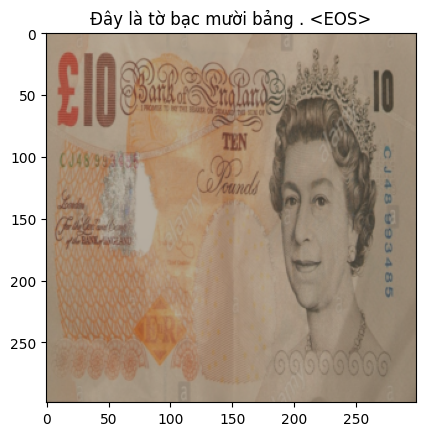

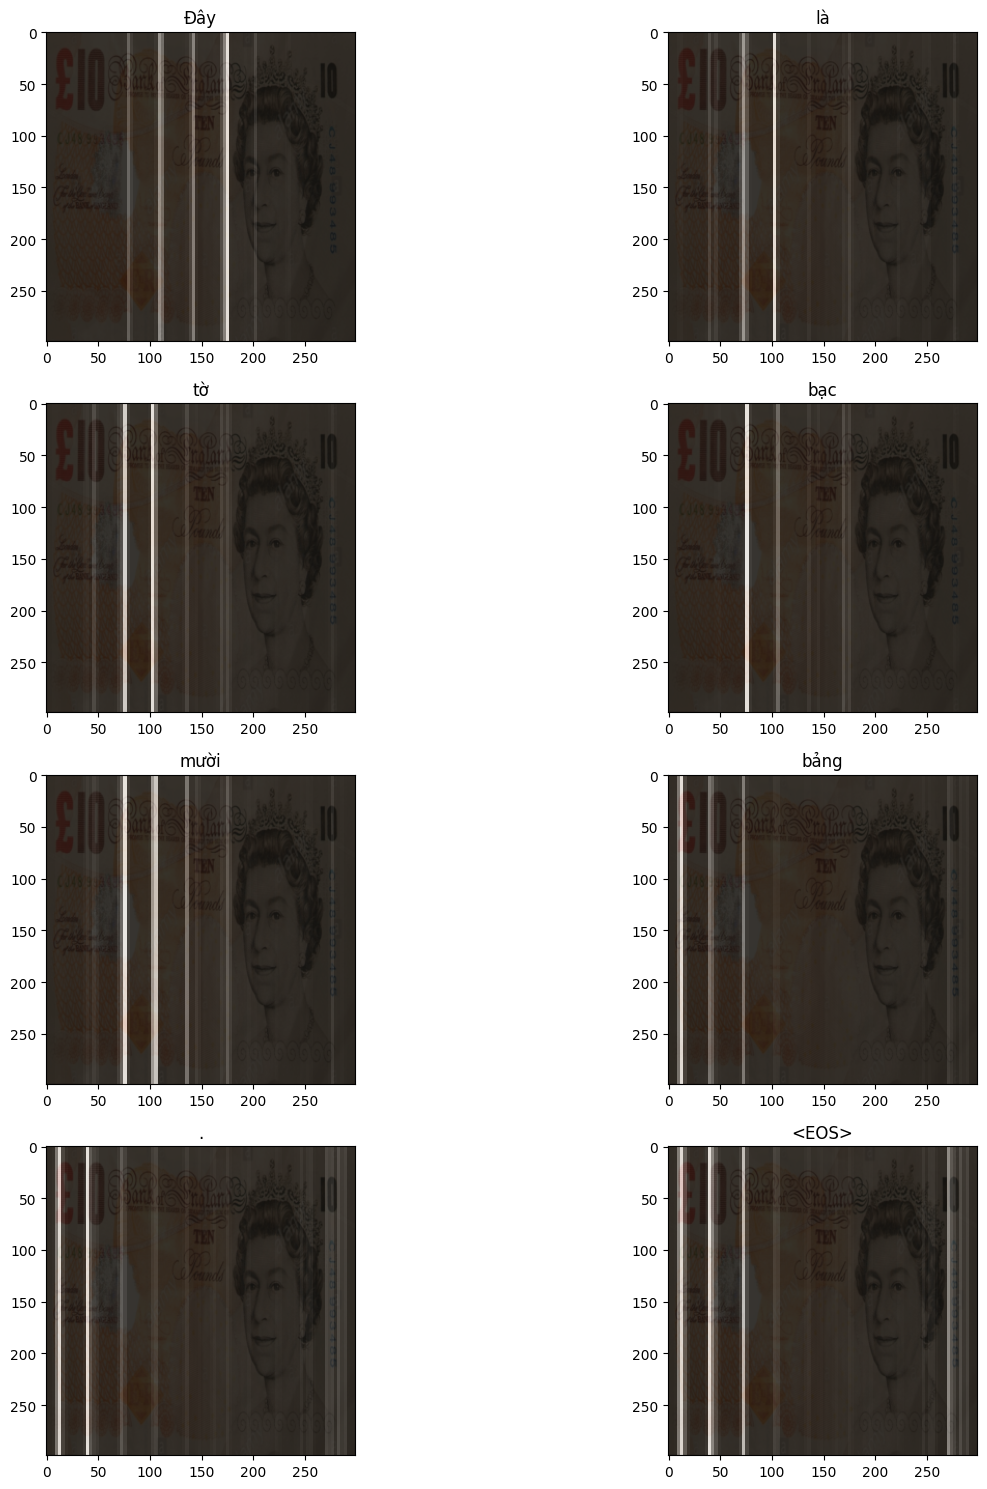

In [20]:
#show any 1
dataiter = iter(loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [21]:
def plot_loss(loss_values):
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss over Iterations')
    plt.legend()
    plt.show()


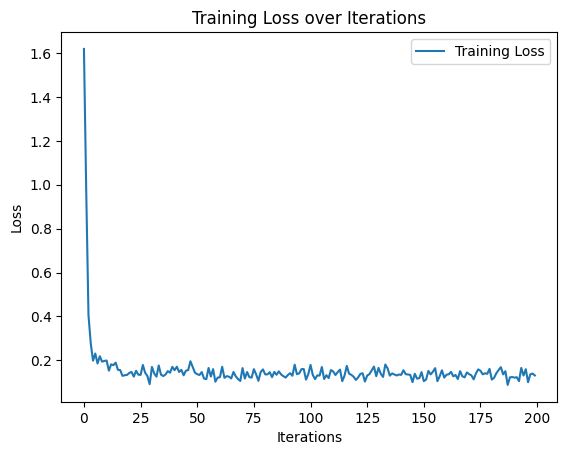

In [22]:
plot_loss(loss_values)

In [23]:
path_test = '/kaggle/input/automatic-image-captioning-for-visually-impaired/visuallyimpair/visual_text/visual.testImages.txt'

In [24]:
class TestDataset(Dataset):
    def __init__(self, root_dir, path_test, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.df = pd.read_csv(path_test, header=None, names=['image'])   
        self.images = self.df['image']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        
        return img

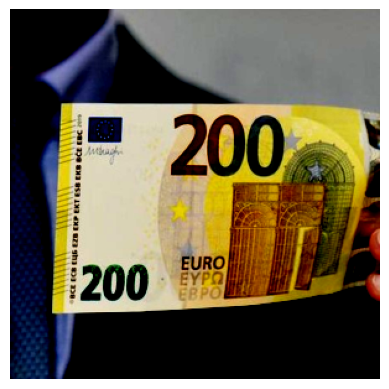

Image 15 Caption: Đây là tờ hai trăm euro . <EOS>


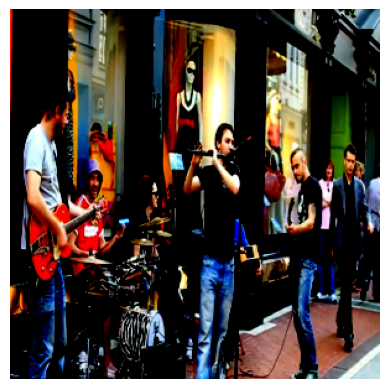

Image 82 Caption: Nhóm người chơi nhạc trên đường_phố . <EOS>


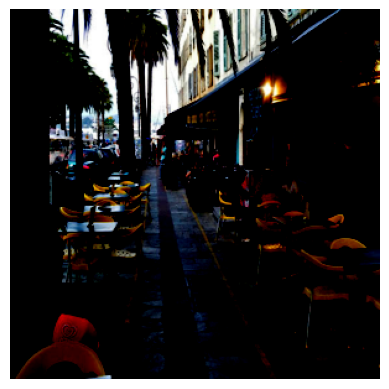

Image 96 Caption: Bạn đang đi về phía nhà_hàng ngoài_trời . <EOS>


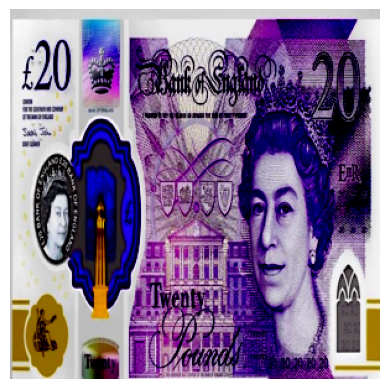

Image 202 Caption: Đây là tờ hai mươi bảng Anh . <EOS>


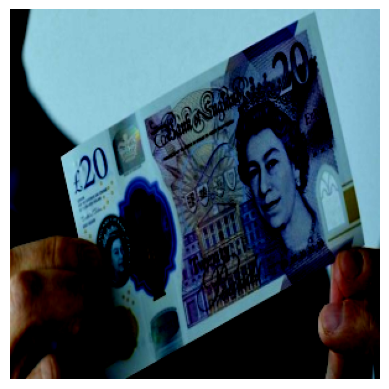

Image 393 Caption: Đây là tờ hai mươi bảng Anh . <EOS>


In [25]:
test_dataset = TestDataset(root_dir=path_img, path_test=path_test, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)  # Shuffle the dataset

def evaluate_and_display_random_samples(model, loader, device, num_samples=5):
    model.eval()

    # Get a random sample of 5 indices
    random_indices = random.sample(range(len(loader)), num_samples)

    with torch.no_grad():
        for i, images in enumerate(loader):
            if i not in random_indices:
                continue

            images = images.to(device)
            features = model.encoder(images)
            captions, _ = model.decoder.generate_caption(features, max_len=20, vocab=dataset.vocab)
            
            # Convert the image tensor to numpy array for display
            image_np = images.squeeze().cpu().numpy()
            
            # Display the image
            plt.imshow(image_np.transpose(1, 2, 0))
            plt.axis('off')
            plt.show()
            
            # Print the predicted caption
            print(f"Image {i+1} Caption: {' '.join(captions)}")

# Evaluate and display 5 random samples with predicted captions
evaluate_and_display_random_samples(model, test_loader, device, num_samples=5)
